In [1]:
rm(list = ls())
options(stringsAsFactors = F)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,626434,33.5,1644548,87.9,1644548,87.9
Vcells,1353242,10.4,8388608,64.0,4881410,37.3


In [3]:
library(DESeq2)
library(bnlearn)
library(org.Hs.eg.db)
library(GEOquery)
library(clusterProfiler)
library(dplyr)
library(limma)

## 原始数据的整理

In [5]:
getx_data <- data.table::fread("./00.data/gtex/gtex_gene_expected_count",data.table = F)  
phenotype <- data.table::fread("./00.data/gtex/GTEX_phenotype",data.table = F)
phenotype <- phenotype %>% filter(phenotype$`_primary_site` == "Stomach")
selectdata <- getx_data[,colnames(getx_data) %in% phenotype$Sample] 
selectdata1 <- cbind(getx_data[,1],selectdata)

#### 截取selectdata数据中的ENSG_ID,该步骤对后面的CBNplot包的使用非常重要！！！CBNplot需要ENSG_ID！！！

In [6]:
ensg <- sapply(selectdata1$`getx_data[, 1]`, function(x) substr(x,1,15))

In [7]:
mydata <- cbind(ensg,selectdata1)

In [8]:
head(mydata)

,ensg,"getx_data[, 1]",GTEX-QLQ7-0826-SM-447B3,GTEX-132AR-2426-SM-5IFFD,GTEX-11EQ9-1226-SM-5987E,GTEX-RWS6-0926-SM-47JXE,GTEX-13X6H-1626-SM-5Q5CT,GTEX-ZTX8-0426-SM-59HLG,GTEX-11EM3-1026-SM-5A5KL,GTEX-S3XE-1026-SM-4AD4O,⋯,GTEX-1122O-1926-SM-5EGIQ,GTEX-13O61-1126-SM-5L3FI,GTEX-ZPIC-2026-SM-57WG3,GTEX-Y9LG-1026-SM-5IFJN,GTEX-13O3Q-2126-SM-5KM4C,GTEX-ZLV1-0826-SM-4WWEQ,GTEX-PX3G-1526-SM-48U11,GTEX-13FTX-0726-SM-5N9BI,GTEX-WFG7-1326-SM-4LMK1,GTEX-12C56-0526-SM-5FQST
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268.2,ENSG00000242268,ENSG00000242268.2,1.0000,1.5850,1.5850,1.0000,2.0000,0.0000,0.0000,1.0000,⋯,1.5850,2.0000,0.0000,1.0000,2.8074,0.0000,0.0000,1.5850,1.0000,1.5850
ENSG00000259041.1,ENSG00000259041,ENSG00000259041.1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ENSG00000270112.3,ENSG00000270112,ENSG00000270112.3,1.0000,0.0000,0.0000,0.0000,0.0000,1.5850,0.0000,1.5850,⋯,0.0000,1.0000,0.0000,1.0000,1.0000,1.5850,1.9561,0.0000,0.0000,0.0000
ENSG00000167578.16,ENSG00000167578,ENSG00000167578.16,8.8543,9.0328,8.9683,9.0298,9.6756,9.1426,8.6864,9.3345,⋯,8.6554,9.1817,9.2099,9.7245,8.9106,9.9282,8.5038,9.4118,9.3541,9.1145
ENSG00000278814.1,ENSG00000278814,ENSG00000278814.1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ENSG00000078237.5,ENSG00000078237,ENSG00000078237.5,6.8826,6.8948,8.1799,6.7004,8.0168,8.2479,7.0768,6.6294,⋯,6.7814,7.7415,7.4009,7.3576,6.6724,7.5622,5.7279,7.5236,7.6865,7.5850


#### 将ENSG_id作为行名

In [9]:
rownames(mydata) <- mydata[,1]
mydata <- mydata[,-c(1:2)]

#### 最终需要的数据格式

In [10]:
head(mydata)

,GTEX-QLQ7-0826-SM-447B3,GTEX-132AR-2426-SM-5IFFD,GTEX-11EQ9-1226-SM-5987E,GTEX-RWS6-0926-SM-47JXE,GTEX-13X6H-1626-SM-5Q5CT,GTEX-ZTX8-0426-SM-59HLG,GTEX-11EM3-1026-SM-5A5KL,GTEX-S3XE-1026-SM-4AD4O,GTEX-ZYY3-1726-SM-5EGH3,GTEX-111YS-1126-SM-5GZYQ,⋯,GTEX-1122O-1926-SM-5EGIQ,GTEX-13O61-1126-SM-5L3FI,GTEX-ZPIC-2026-SM-57WG3,GTEX-Y9LG-1026-SM-5IFJN,GTEX-13O3Q-2126-SM-5KM4C,GTEX-ZLV1-0826-SM-4WWEQ,GTEX-PX3G-1526-SM-48U11,GTEX-13FTX-0726-SM-5N9BI,GTEX-WFG7-1326-SM-4LMK1,GTEX-12C56-0526-SM-5FQST
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000242268,1.0000,1.5850,1.5850,1.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,⋯,1.5850,2.0000,0.0000,1.0000,2.8074,0.0000,0.0000,1.5850,1.0000,1.5850
ENSG00000259041,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ENSG00000270112,1.0000,0.0000,0.0000,0.0000,0.0000,1.5850,0.0000,1.5850,0.0000,1.0000,⋯,0.0000,1.0000,0.0000,1.0000,1.0000,1.5850,1.9561,0.0000,0.0000,0.0000
ENSG00000167578,8.8543,9.0328,8.9683,9.0298,9.6756,9.1426,8.6864,9.3345,9.3502,8.6179,⋯,8.6554,9.1817,9.2099,9.7245,8.9106,9.9282,8.5038,9.4118,9.3541,9.1145
ENSG00000278814,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ENSG00000078237,6.8826,6.8948,8.1799,6.7004,8.0168,8.2479,7.0768,6.6294,6.2288,6.9658,⋯,6.7814,7.7415,7.4009,7.3576,6.6724,7.5622,5.7279,7.5236,7.6865,7.5850


#### 将数据转换成counts格式

In [11]:
rt=avereps(mydata)
rt <-  2^rt-1
rt <- round(rt,0)

In [12]:
head(rt)

,GTEX-QLQ7-0826-SM-447B3,GTEX-132AR-2426-SM-5IFFD,GTEX-11EQ9-1226-SM-5987E,GTEX-RWS6-0926-SM-47JXE,GTEX-13X6H-1626-SM-5Q5CT,GTEX-ZTX8-0426-SM-59HLG,GTEX-11EM3-1026-SM-5A5KL,GTEX-S3XE-1026-SM-4AD4O,GTEX-ZYY3-1726-SM-5EGH3,GTEX-111YS-1126-SM-5GZYQ,⋯,GTEX-1122O-1926-SM-5EGIQ,GTEX-13O61-1126-SM-5L3FI,GTEX-ZPIC-2026-SM-57WG3,GTEX-Y9LG-1026-SM-5IFJN,GTEX-13O3Q-2126-SM-5KM4C,GTEX-ZLV1-0826-SM-4WWEQ,GTEX-PX3G-1526-SM-48U11,GTEX-13FTX-0726-SM-5N9BI,GTEX-WFG7-1326-SM-4LMK1,GTEX-12C56-0526-SM-5FQST
ENSG00000242268,1,2,2,1,3,0,0,1,0,0,⋯,2,3,0,1,6,0,0,2,1,2
ENSG00000259041,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000270112,1,0,0,0,0,2,0,2,0,1,⋯,0,1,0,1,1,2,3,0,0,0
ENSG00000167578,462,523,500,522,817,564,411,645,652,392,⋯,402,580,591,845,480,973,362,680,653,553
ENSG00000278814,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000078237,117,118,289,103,258,303,134,98,74,124,⋯,109,213,168,163,101,188,52,183,205,191


In [13]:
geo <- data.table::fread("./BIM课题研究结果/04BIM相关靶点基因筛选/数据下载/GEO/GSE191275_genes_fpkm_expression - 副本.txt",data.table = F)
rownames(geo)=geo[,1]
geo <- geo[,-1]

In [14]:
head(geo)

,count.GC1,count.GC10,count.GC2,count.GC3,count.GC4,count.GC5,count.GC6,count.GC7,count.GC8,count.GC9,count.IM1,count.IM10,count.IM2,count.IM3,count.IM4,count.IM5,count.IM6,count.IM7,count.IM8,count.IM9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,953,1613,1077,1656,1262,1155,1351,731,1679,782,1244,1444,1129,1149,1140,1596,1130,973,616,1216
ENSG00000000005,0,0,0,19,41,0,0,12,0,0,0,0,0,4,0,0,4,0,0,0
ENSG00000000419,1891,1803,1667,1852,1998,1335,1748,1109,1607,1284,1132,1888,1038,1187,1388,1419,1280,1191,1154,1534
ENSG00000000457,1228,1222,1109,1452,1032,1367,1209,819,1069,1029,945,1169,1052,792,995,1312,1120,961,781,916
ENSG00000000460,429,1050,581,802,285,395,410,482,446,296,365,397,194,186,233,459,468,189,82,190
ENSG00000000938,2776,2051,1238,1767,2261,2110,919,1339,1278,2273,170,159,64,174,301,240,207,141,241,206


#### 整合两个数据

In [15]:
same <- intersect(rownames(rt),rownames(geo))
result <- cbind(rt[same,],geo[same,])

In [16]:
head(result)

,GTEX-QLQ7-0826-SM-447B3,GTEX-132AR-2426-SM-5IFFD,GTEX-11EQ9-1226-SM-5987E,GTEX-RWS6-0926-SM-47JXE,GTEX-13X6H-1626-SM-5Q5CT,GTEX-ZTX8-0426-SM-59HLG,GTEX-11EM3-1026-SM-5A5KL,GTEX-S3XE-1026-SM-4AD4O,GTEX-ZYY3-1726-SM-5EGH3,GTEX-111YS-1126-SM-5GZYQ,⋯,count.IM1,count.IM10,count.IM2,count.IM3,count.IM4,count.IM5,count.IM6,count.IM7,count.IM8,count.IM9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000242268,1,2,2,1,3,0,0,1,0,0,⋯,0,26,0,0,9,14,20,12,12,12
ENSG00000259041,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000270112,1,0,0,0,0,2,0,2,0,1,⋯,1,0,11,4,7,10,8,1,12,0
ENSG00000167578,462,523,500,522,817,564,411,645,652,392,⋯,877,1794,985,850,912,1075,978,1088,1215,1980
ENSG00000078237,117,118,289,103,258,303,134,98,74,124,⋯,372,1512,445,414,627,875,486,891,1000,1335
ENSG00000269416,2,0,3,0,0,0,1,3,0,1,⋯,232,381,191,292,294,409,402,206,99,143


#### 下面进行DESeq2分析，CBNplot的使用需要DESeq的处理结果

In [18]:
data1 <- result[,c(175:184,1:174)]   ####挑选胃癌和正常组织进行差异性分析
coldata1 <- data.frame(condition = factor(c(rep('GC',10),rep('NOR',174)),
                                          levels = c('GC', 'NOR')))
rownames(coldata1) <- colnames(data1)

In [19]:
dds1 <- DESeqDataSetFromMatrix(countData = data1, colData = coldata1, design= ~condition)
filt <- rowSums(counts(dds1) < 10) > dim(coldata1)[1]*0.9  ###筛选数据
dds1 <- dds1[!filt,]
dds1.1 <- DESeq(dds1)
res = results(dds1.1, pAdjustMethod = "bonferroni")
myres <- data.frame(res)  #可视化res结果
v = vst(dds1.1, blind=FALSE)
vsted = assay(v)
#####最终需要对res结果进行筛选，进一步进行kegg分析和CBNplot绘图

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 384 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



#### 载入我们需要的基因，在res结果中筛选出这些基因

In [21]:
gene <- data.table::fread("./step1-TCSMP/myCytoscape/net.geneList.txt",
                          data.table = F,header = F)
gene <- as.vector(gene$V1)
ENS <- mapIds(org.Hs.eg.db,keys = gene,keytype ="SYMBOL",column = "ENSEMBL")  ###将基因id转化成ENSG_id,这一步很重要

'select()' returned 1:many mapping between keys and columns



In [22]:
sig1 = subset(res, res@rownames %in% ENS)#####从res中将我们关注的基因挑选出来
cand.entrez = clusterProfiler::bitr(rownames(sig1), 
                                    fromType="ENSEMBL", 
                                    toType="ENTREZID", 
                                    OrgDb=org.Hs.eg.db)$ENTREZID ###gene_id的转换

'select()' returned 1:1 mapping between keys and columns



#### 对我们关注的gene进行kegg分析

In [24]:
pway = ReactomePA::enrichPathway(gene = cand.entrez) ###kegg分析
pway = setReadable(pway, OrgDb=org.Hs.eg.db)

#### kegg结果可视化

In [25]:
kegg=data.frame(pway)

## CBNplot绘图

In [27]:
library(CBNplot)

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

Warning message in averaged.network.backend(strength = strength, threshold = threshold):
"arc CCR5 -> PDE4C would introduce cycles in the graph, ignoring."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

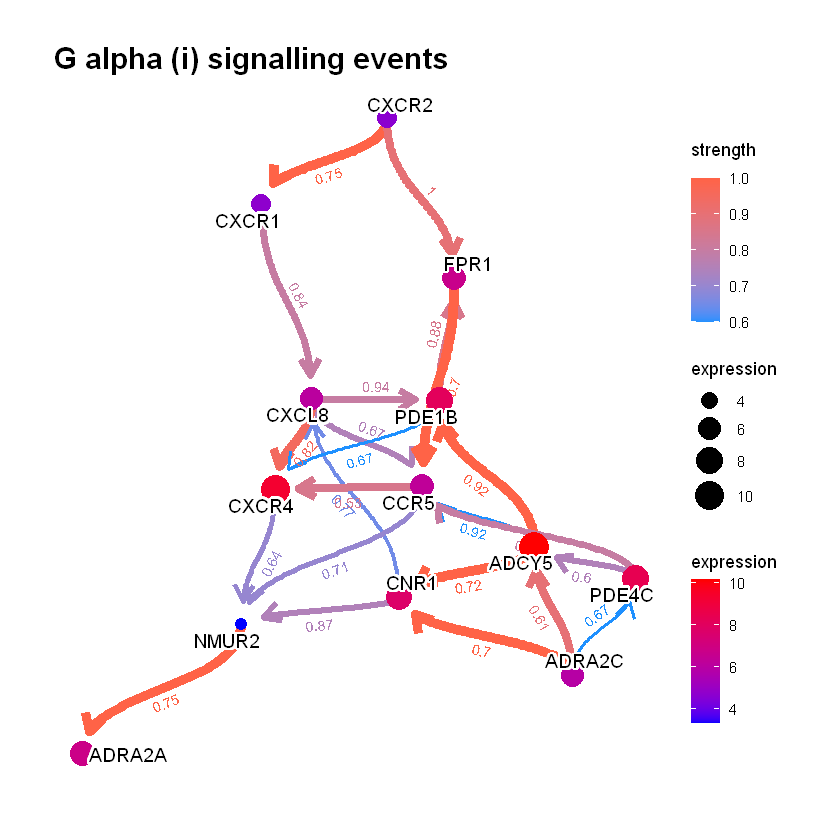

In [29]:
bngeneplot(results = pway, 
           exp = vsted, 
           pathNum = 2,###选择哪个通路
           
           R=20,#自举次数
           convertSymbol = T,
           strThresh = 0.6,
           showDir = T, expRow = "ENSEMBL")  ####目前看来expRow只能选择"ENSEMBL"，选择“SYMBOL”会报错